# Part 1: Gathering Data


In [124]:
from pathlib import Path
import time
import warnings
warnings.filterwarnings("ignore")
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path

def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        download_file_from_google_drive(gdrive_id, file_path)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path



# https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    needs_confirm = needs_confirmation(response)

    if needs_confirm:
        params = { 'id' : id, 'confirm' : 't' ,}
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def needs_confirmation(response):

    return response.headers["Content-Type"] == 'text/html; charset=utf-8'

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# download required datasets

file_dict = {
    "aqs_sites.csv": "1fMfkw-NJ03VrQxYpDjM_4T6VDaWhvegi",
    "greenhouse_gas_emmitter_facilities.csv": "1yjTRv1OrsdWk-xNW4ZbFYB7_8Tt_x_fV",
    "greenhouse_gas_emmiter_gas_types.csv":"1akEokx_wqsgYqGNnNJsgebA6DDGHJLR2",
    "2020_daily_global_weather.csv":"15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ",
    "daily_wind_2020.csv": "18MqsjkN0EYPuLb0iR0U9sZYmNVCdd94h",
    "daily_temperature_2020.csv": "1Q62JlGtc65L2eU9FfQZcP9UyMCdcem1T",
    "traffic_volumes.csv": "1sZyjZSWz1xEoB26u_OrhKokZYhTIJRMD",
    "county_aqi_2020_daily.csv": "1uNH90XRceOfb16ctuUsYXVIEDeR2yaeC"
    }

for k, v in file_dict.items():
    path = f"./datasets/{k}"
    if not os.path.exists(path):
        download_file_from_google_drive(v,path)



## Data wrangling

### decisions log
- we are going to only use data for the state of california because we are interested in using vehicle emissions data which we have for the state of california in addition to the factory emissions data 

## Creating Dataframes

In [125]:
import pandas as pd
daily_global_weather_2020 = pd.read_csv("datasets/2020_daily_global_weather.csv").drop(columns="Unnamed: 0")

us_greenhouse_gas_emission_direct_emitter_gas_type = pd.read_csv("datasets/greenhouse_gas_emmiter_gas_types.csv", low_memory=False)

aqi_sites = pd.read_csv("datasets/aqs_sites.csv")

daily_county_aqi = pd.read_csv("datasets/county_aqi_2020_daily.csv") 

daily_temp = pd.read_csv("datasets/daily_temperature_2020.csv")

daily_wind = pd.read_csv("datasets/daily_wind_2020.csv")

traffic_volumes = pd.read_csv("datasets/traffic_volumes.csv")

## "AQI by county" shows the annual distribution of AQI and ratings by State and County. Each row represents the AQI distribution of a State and County pair.

## "daily global weather 2020" shows the daily average temperature and precipitation on a global scale. Each row represents a specific station somewhere in the world per day.

## "US greenhouse gas emission" shows CO2 equivalent green house gas emissions for various greehhouse gasses by state, county, city and year. Each row represents a CO2 equivalent green house gas emission for a speific gas in a city by year.

## "aqi sites" has meta deta about the AQI sites where AQI values are measured and determined. Each row is a site.

## "daily_county_aqi" shows the daily AQI and its defining parameter for a State and County. Each row represents a day for each state and county pair.

## "daily_temp" shows the average daily temperature for a state and county. Each row represents a day for each state and county pair. (City column exists but does not apply to all rows)

## "daily_wind" shows the average wind speed and wind direction for a state and county. Each row represents a day for each state and county pair. (City column exists but does not apply to all rows)

In [126]:
#PRCP is average percipitation in tenths of a mm, TAVG is tempearture average at each station for each day
daily_global_weather_2020

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.3330,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.2550,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.2100,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.0500,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.7200,4.0500,222.0,0.0
...,...,...,...,...,...,...,...
1064278,USW00094847,2020-10-22,96.0,42.2314,-83.3308,192.3,157.0
1064279,USW00094849,2020-10-22,67.0,45.0717,-83.5644,208.5,99.0
1064280,USW00094860,2020-10-22,77.0,42.8939,-85.5447,237.1,165.0
1064281,USW00094908,2020-10-22,73.0,42.3978,-90.7036,321.9,361.0


In [127]:
us_greenhouse_gas_emission_direct_emitter_gas_type.columns

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')

In [128]:
daily_county_aqi.columns

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')

In [129]:
aqi_sites.columns

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')

#### The defining site column in daily_county_aqi is defined by "State Code"-"County Code"-"Site Number" for a given State and County in aqi_sites. Thus, the City name can be determined by the defining site using the aqi_sites table, if increased granularity is required.

In [130]:
daily_wind.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

## Aggregating Daily temp, wind speed and wind direction by state and county

In [131]:
# Data Prep on daily temperature, wind speed and wind direction

# Extracting relevant columns
truncated_daily_temp = daily_temp[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local", "Arithmetic Mean"]]

# Array of US States and territories
US_States_territories = us_greenhouse_gas_emission_direct_emitter_gas_type["V_GHG_EMITTER_GAS.STATE_NAME"].unique()

# Only US States and territories should be in our data
truncated_daily_temp = truncated_daily_temp[truncated_daily_temp["State Name"].str.upper().isin(US_States_territories)]

# Impute missing 0s, with mean of the arithmetic mean, there are no null values
truncated_daily_temp["Arithmetic Mean"] = truncated_daily_temp["Arithmetic Mean"].replace(0, truncated_daily_temp["Arithmetic Mean"].mean())

# Rename Arithmetic Mean column to include temperature and units (Temp - F)
truncated_daily_temp = truncated_daily_temp.rename(columns={"Arithmetic Mean": "Mean Temperature (F)"})

In [132]:
truncated_daily_temp

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F)
0,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-01,53.540000
1,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-02,67.342857
2,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-03,26.580000
3,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-04,44.830000
4,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-05,51.550000
...,...,...,...,...,...,...,...,...,...,...
290326,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-27,31.000000
290327,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-28,26.000000
290328,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-29,22.958333
290329,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-30,14.583333


## Data Prep on Daily Wind Data

In [133]:
# Extract relevant Columns
truncated_daily_wind = daily_wind[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Parameter Name", "Date Local", "Arithmetic Mean"]]

# Only US States and territories should be in our data
truncated_daily_wind = truncated_daily_wind[truncated_daily_wind["State Name"].str.upper().isin(US_States_territories)]

# Seperate wind direction and wind speed before imputing missing values
daily_wind_speed = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Speed - Resultant"].reset_index(drop=True)

daily_wind_direction = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Direction - Resultant"].reset_index(drop=True)

# Impute missing values or 0 values with mean of the column
daily_wind_speed["Arithmetic Mean"] = daily_wind_speed["Arithmetic Mean"].replace(0, daily_wind_speed["Arithmetic Mean"].mean())

daily_wind_direction["Arithmetic Mean"] = daily_wind_direction["Arithmetic Mean"].replace(0, daily_wind_direction["Arithmetic Mean"].mean())

# Rename Arithmetic Mean columns to include the measurement and units
daily_wind_speed = daily_wind_speed.rename(columns={"Arithmetic Mean": "Mean Wind Speed (knots)"}).drop(columns=["Parameter Name"])
daily_wind_direction = daily_wind_direction.rename(columns={"Arithmetic Mean": "Mean Wind Direction (compass degrees)"}).drop(columns=["Parameter Name"])

In [134]:
daily_wind_speed

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,4.349492
...,...,...,...,...,...,...,...,...,...,...
239426,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,1.795833
239427,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,1.212500
239428,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,1.441667
239429,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,1.466667


In [135]:
daily_wind_direction

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Direction (compass degrees)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,179.900000
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,108.857143
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,271.000000
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,230.100000
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,251.100000
...,...,...,...,...,...,...,...,...,...,...
242333,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,190.375000
242334,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,171.375000
242335,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,181.166667
242336,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,173.666667


## Merging the wind, and temperature data

In [136]:
wind_data_merge = pd.merge(daily_wind_direction, daily_wind_speed, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

In [137]:
weather_data = truncated_daily_temp.merge(wind_data_merge, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

## Final dataset which includes weather data

In [138]:
weather_data

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492
...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667


In [139]:
len(weather_data["City Name"].unique())

368

## Incorporating land use, elevation and location setting for the AQI sites into weather data set as features

In [140]:
truncated_aqi_sites = aqi_sites[["State Code", "County Code", "Site Number", "State Name", "County Name", "City Name", "Elevation", "Land Use", "Location Setting"]].rename(columns={"Site Number": "Site Num"})

# Only showing US and territories aqi sites
truncated_aqi_sites = truncated_aqi_sites[truncated_aqi_sites["State Name"].str.upper().isin(US_States_territories)]

truncated_aqi_sites["State Code"] = truncated_aqi_sites["State Code"].astype(int)

In [141]:
truncated_aqi_sites[(truncated_aqi_sites["State Name"] == "Alabama") & (truncated_aqi_sites["County Name"] == "Escambia")]

,State Code,County Code,Site Num,State Name,County Name,City Name,Elevation,Land Use,Location Setting
80,1,53,1,Alabama,Escambia,Brewton,37.00,RESIDENTIAL,SUBURBAN
81,1,53,2,Alabama,Escambia,Brewton,50.00,COMMERCIAL,URBAN AND CENTER CITY
82,1,53,1000,Alabama,Escambia,Not in a City,89.61,AGRICULTURAL,RURAL


In [142]:
truncated_aqi_sites

,State Code,County Code,Site Num,State Name,County Name,City Name,Elevation,Land Use,Location Setting
0,1,1,1,Alabama,Autauga,Prattville,64.0,RESIDENTIAL,SUBURBAN
1,1,1,2,Alabama,Autauga,Prattville,0.0,AGRICULTURAL,RURAL
2,1,1,3,Alabama,Autauga,Not in a City,41.0,FOREST,RURAL
3,1,3,1,Alabama,Baldwin,Not in a city,0.0,UNKNOWN,RURAL
4,1,3,2,Alabama,Baldwin,Robertsdale,0.0,COMMERCIAL,RURAL
...,...,...,...,...,...,...,...,...,...
20680,78,30,5,Virgin Islands,St Thomas,Charlotte Amalie,1.0,COMMERCIAL,URBAN AND CENTER CITY
20681,78,30,6,Virgin Islands,St Thomas,Charlotte Amalie,61.0,RESIDENTIAL,SUBURBAN
20682,78,30,7,Virgin Islands,St Thomas,Charlotte Amalie,15.0,COMMERCIAL,SUBURBAN
20683,78,30,9,Virgin Islands,St Thomas,Charlotte Amalie,0.0,COMMERCIAL,URBAN AND CENTER CITY


In [143]:
feature_set = weather_data.merge(truncated_aqi_sites, on=["State Code", "County Code", "Site Num"])

In [144]:
feature_set = feature_set.drop(columns=["State Name_y", "County Name_y", "City Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x": "County Name", "City Name_x": "City Name"})

In [145]:
feature_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492,89.61,AGRICULTURAL,RURAL
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492,89.61,AGRICULTURAL,RURAL
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492,89.61,AGRICULTURAL,RURAL
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492,89.61,AGRICULTURAL,RURAL
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492,89.61,AGRICULTURAL,RURAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833,2230.00,FOREST,RURAL
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500,2230.00,FOREST,RURAL
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667,2230.00,FOREST,RURAL
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667,2230.00,FOREST,RURAL


## Adding the observed values for AQI to the features dataset

In [146]:
## Extracting the Site Num from Defining Site
daily_county_aqi["Site Num"] = daily_county_aqi["Defining Site"].str.extract(pat=f'\d+-\d+-(\d+)').astype(int)

In [147]:
## Renaming columns to allow for merge
daily_county_aqi = daily_county_aqi.rename(columns={"county Name": "County Name", "Date": "Date Local"})

In [148]:
## Merging with the feature set
final_data_set = feature_set.merge(daily_county_aqi, on=["State Code", "County Code", "Site Num", "Date Local"])

In [149]:
## Dropping redundant columns and renaming 
final_data_set = final_data_set.drop(columns=["State Name_y", "County Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x":"County Name", "Date Local": "Date"})

In [150]:
pd.set_option('display.expand_frame_repr', False)
final_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-09,52.125000,137.125000,4.904167,177.0,COMMERCIAL,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9
1,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-10,65.750000,163.708333,7.583333,177.0,COMMERCIAL,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9
2,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-14,63.937500,208.916667,3.166667,177.0,COMMERCIAL,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9
3,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-16,58.012500,75.458333,5.945833,177.0,COMMERCIAL,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9
4,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-17,54.945833,105.375000,5.491667,177.0,COMMERCIAL,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94814,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-05,45.708333,162.666667,2.287500,2230.0,FOREST,RURAL,54,Moderate,PM2.5,56-039-1013,3
94815,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-07,44.083333,174.791667,2.087500,2230.0,FOREST,RURAL,85,Moderate,PM2.5,56-039-1013,3
94816,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-08,46.375000,169.375000,3.016667,2230.0,FOREST,RURAL,69,Moderate,PM2.5,56-039-1013,3
94817,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-09,45.041667,168.666667,2.612500,2230.0,FOREST,RURAL,55,Moderate,PM2.5,56-039-1013,4


## Daily Global Temperatures and Precipitation

## Attempting to incorporate precipitation by state/county/city as predicted by reverse geocoder as features 

In [151]:
only_US_daily_global_weather = daily_global_weather_2020.loc[daily_global_weather_2020["Station"].str.contains('^US')]

In [152]:
only_US_daily_global_weather

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
2542,USS0003E03S,2020-01-01,-8.0,44.1100,-103.9800,2100.1,51.0
2543,USS0003E05S,2020-01-01,15.0,44.2100,-103.7900,1868.4,25.0
2544,USS0004E07S,2020-01-01,14.0,44.4900,-104.4100,1801.4,51.0
2545,USS0005G04S,2020-01-01,-49.0,42.4400,-105.8600,2552.7,25.0
2546,USS0005G05S,2020-01-01,-42.0,42.2800,-105.5800,2407.9,0.0
...,...,...,...,...,...,...,...
1064278,USW00094847,2020-10-22,96.0,42.2314,-83.3308,192.3,157.0
1064279,USW00094849,2020-10-22,67.0,45.0717,-83.5644,208.5,99.0
1064280,USW00094860,2020-10-22,77.0,42.8939,-85.5447,237.1,165.0
1064281,USW00094908,2020-10-22,73.0,42.3978,-90.7036,321.9,361.0


In [153]:
latitudes = list(only_US_daily_global_weather['Latitude'])
longitudes = list(only_US_daily_global_weather['Longitude'])

In [154]:
list_coordinates = []
for i in range(len(latitudes)):
    list_coordinates.append((latitudes[i], longitudes[i]))

In [155]:
import reverse_geocoder as rg

#coordinates = [(51.5214588,-0.1729636),(9.936033, 76.259952),(37.38605,-122.08385)]
#print(coordinates)
results = rg.search(list_coordinates) # default mode = 2

city = []
county = []
state = []

for i in results:
    city.append(i['name'])
    county.append(i['admin2'])
    state.append(i['admin1'])


In [156]:
only_US_daily_global_weather['State Name'] = state
only_US_daily_global_weather['County Name'] = county
only_US_daily_global_weather['City Name'] = city

In [157]:
only_US_daily_global_weather.columns

Index(['Station', 'Date', 'TAVG', 'Latitude', 'Longitude', 'Elevation', 'PRCP',
       'State Name', 'County Name', 'City Name'],
      dtype='object')

In [158]:
feature_set.columns

Index(['State Code', 'County Code', 'Site Num', 'State Name', 'County Name',
       'City Name', 'Latitude', 'Longitude', 'Date Local',
       'Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
       'Mean Wind Speed (knots)', 'Elevation', 'Land Use', 'Location Setting'],
      dtype='object')

In [159]:
final_data_set_2 = final_data_set.merge(only_US_daily_global_weather, on=["State Name", "County Name", "City Name", "Date"])

In [160]:
final_data_set_2

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude_x,Longitude_x,Date,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation_x,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Station,TAVG,Latitude_y,Longitude_y,Elevation_y,PRCP


## We are unable to add precipitation data because we cannot join on the State, County, City names and Date found in our final data set and the daily US global weather data frame. This is because the 4 columns we want to join on are not identical in the data sets indicating that we don't have data for those locations in both data sets. This is not unsurprising as we are "estimating" the State, County and City names using Latitudes and Logitudes and the reverse_geocoder library. Thus we will be moving forward with the final_data_set data frame.

## Attempting to Incorporate the EPA emissions prevention data set

In [161]:
epa_emissions_prevention_2020 = pd.read_csv("./datasets/epa_test_2.csv")

In [162]:
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}

epa_emissions_prevention_2020["State"] = epa_emissions_prevention_2020["Address"].str.extract(",([A-Z]{2}) \d{5,9}$")
epa_emissions_prevention_2020["State"] = epa_emissions_prevention_2020["State"].replace(states)
epa_emissions_prevention_2020["City"] = epa_emissions_prevention_2020["Address"].str.extract(",\W?([a-zA-Z]+),\W?[A-Z]{2} \d{5,9}$")

In [163]:
epa_emissions_prevention_2020

,TRI Facility ID,Facility Name,Address,Chemical Name,Industry,Prior Year Release *,Current Year Release *,Percent Change,Pollution Prevention Information (Activity Codes/Text/[Reduction]),P2 Report,State,City
0,37660HLSTNWESTS,US ARMY HOLSTON ARMY AMMUNITION PLANT (US DEPA...,"4509 W STONE DR, KINGSPORT,TN 37660","Sulfuric acid (acid aerosols including mists, ...",928110: National Security,"31,424.00",0,-100%,"Source Reduction: W52: Modified equipment, lay...",NaN,Tennessee,KINGSPORT
1,42223SRMYF8MILE,US ARMY FORT CAMPBELL (US DEPARTMENT OF DEFENSE),"IMCB PWE BLDG 5134 2ND ST & WICKHAM AVE, FORT ...",Lead compounds,928110: National Security,"3,775.00",0,-100%,Source Reduction: Source Reduction - Due to C...,NaN,Kentucky,NaN
2,40475SRMYB2091K,US ARMY BLUE GRASS ARMY DEPOT (US DEPARTMENT O...,431 BATTLEFIELD MEMORIAL HWY ATTN: JMBG SSE BL...,Lead compounds,928110: National Security,"1,575.60",0,-100%,Source Reduction: W19: Other changes in operat...,NaN,Kentucky,RICHMOND
3,92055MRNCRPOBOX,US MARINE CORPS MCB CAMP PENDLETON (US DEPARTM...,"BLDG 22165 11TH ST, CAMP PENDLETON,CA 920558008",Lead compounds,928110: National Security,500.80,0,-100%,Source Reduction: W82: Modified design or comp...,NaN,California,NaN
4,92055MRNCRPOBOX,US MARINE CORPS MCB CAMP PENDLETON (US DEPARTM...,"BLDG 22165 11TH ST, CAMP PENDLETON,CA 920558008",Lead compounds,928110: National Security,500.80,0,-100%,Source Reduction: W21: Instituted procedures t...,NaN,California,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2840,89319BHPCP7MILE,ROBINSON NEVADA MINING CO (NA),"4232 W WHITE PINE CO RD 44, RUTH,NV 89319",Mercury compounds,"212230: Copper, Nickel, Lead, and Zinc Mining",.10,0,-100%,Source Reduction: W49: Other raw material modi...,NaN,Nevada,RUTH
2841,85539BHPCPHWY60,PINTO VALLEY MINE (NA),"2911 N FOREST SERVICE RD 287, MIAMI,AZ 85539",Manganese,"212230: Copper, Nickel, Lead, and Zinc Mining",0,0,0%,"Source Reduction: W52: Modified equipment, lay...",NaN,Arizona,MIAMI
2842,85539BHPCPHWY60,PINTO VALLEY MINE (NA),"2911 N FOREST SERVICE RD 287, MIAMI,AZ 85539",Nickel,"212230: Copper, Nickel, Lead, and Zinc Mining",0,0,0%,"Source Reduction: W52: Modified equipment, lay...",NaN,Arizona,MIAMI
2843,85539BHPCPHWY60,PINTO VALLEY MINE (NA),"2911 N FOREST SERVICE RD 287, MIAMI,AZ 85539",Chromium,"212230: Copper, Nickel, Lead, and Zinc Mining",0,0,0%,"Source Reduction: W52: Modified equipment, lay...",NaN,Arizona,MIAMI


In [164]:
chemical_names = epa_emissions_prevention_2020["Chemical Name"].unique()


## Viewing all chemical names found in the EPA dataset

In [165]:
chemical_names

array(['Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)',
       'Lead compounds', 'Lead', 'Manganese',
       'Dinitrotoluene (mixed isomers)', 'Nitroglycerin',
       'Dibutyl phthalate', 'Nonylphenol Ethoxylates', 'Copper', 'Nickel',
       'Chromium', 'Naphthalene', 'Mercury', 'Ethylene glycol',
       'Polychlorinated biphenyls', 'Methanol', 'Xylene (mixed isomers)',
       'Toluene', 'Acetonitrile', 'Methyl isobutyl ketone', 'Styrene',
       'Ethylbenzene', 'n-Hexane', 'o-Xylene',
       'Barium compounds (except for barium sulfate (CAS No. 7727-43-7))',
       'Cobalt compounds', 'Cyanide compounds', 'Mercury compounds',
       'Certain glycol ethers', 'Nickel compounds',
       'Polycyclic aromatic compounds', 'Zinc compounds', 'Chlorine',
       'Diisocyanates', 'Benzene', 'Cumene', 'Anthracene',
       'Diethanolamine', 'Dichloromethane', 'Nitric acid',
       'N,N-Dimethylformamide', 'Copper compounds', 'Formald

In [166]:
epa_emissions_prevention_2020["current"] = epa_emissions_prevention_2020["Current Year Release *"].astype(str).str.replace(',','').astype(np.float64)
epa_emissions_prevention_2020["prior"] = epa_emissions_prevention_2020["Prior Year Release *"].astype(str).str.replace(',','').astype(np.float64)

## Calculating the sum of each chemical for the state

In [167]:
state_emission_prevention = epa_emissions_prevention_2020.groupby(["State","Chemical Name"])["current","prior"].agg("sum").reset_index()
city_emission_prevention = epa_emissions_prevention_2020.groupby(["City","Chemical Name"])["current","prior"].agg("sum").reset_index()

state_emission_prevention

,State,Chemical Name,current,prior
0,Alabama,"2,4-Dichlorophenol",0.0,10.00
1,Alabama,Acetaldehyde,0.0,41000.00
2,Alabama,Ammonia,0.0,16431.00
3,Alabama,Antimony compounds,0.0,10.00
4,Alabama,Barium compounds (except for barium sulfate (C...,0.0,619.50
...,...,...,...,...
1247,Wyoming,Naphthalene,0.0,41.70
1248,Wyoming,Styrene,0.0,45.16
1249,Wyoming,Toluene,0.0,1420.80
1250,Wyoming,Xylene (mixed isomers),0.0,1206.20


In [168]:
state_emission_pivot = state_emission_prevention.pivot_table("prior", ["State"], "Chemical Name").reset_index("State").fillna(0)

state_emission_pivot

Chemical Name,State,"1,2-Butylene oxide","1,2-Dibromoethane","1,2-Dichloroethane","1,3-Butadiene","1,4-Dichlorobenzene","2,4-D 2-ethylhexyl ester","2,4-Dichlorophenol","2,4-Dimethylphenol","4,4'-Methylenedianiline",Acetaldehyde,Acetonitrile,Acrylic acid,Acrylonitrile,Aluminum (fume or dust),Aluminum oxide (fibrous forms),Ammonia,Aniline,Anthracene,Antimony,Antimony compounds,Arsenic,Arsenic compounds,Barium compounds (except for barium sulfate (CAS No. 7727-43-7)),Benzene,"Benzo[g,h,i]perylene",Benzyl chloride,Biphenyl,Cadmium,Cadmium compounds,Carbaryl,Carbon disulfide,Carbonyl sulfide,Certain glycol ethers,Chlorine,Chloroacetic acid,Chlorobenzene,Chloroethane,Chloroform,Chloromethane,...,Phosphorus (yellow or white),Phthalic anhydride,Polychlorinated biphenyls,Polycyclic aromatic compounds,Propionaldehyde,Propylene oxide,Pyridine,Quintozene,Silver,Silver compounds,Sodium nitrite,Styrene,"Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)",Tetrachloroethylene,Thiodicarb,Thiourea,Thiram,Toluene,Toluene diisocyanate (mixed isomers),"Toluene-2,4-diisocyanate","Toluene-2,6-diisocyanate",Trichloroethylene,Trichlorofluoromethane (CFC-11),Triethylamine,Vanadium compounds,Vinyl acetate,Vinyl chloride,Vinylidene chloride,Xylene (mixed isomers),Zinc (fume or dust),Zinc compounds,m-Cresol,m-Xylene,n-Butyl alcohol,n-Hexane,o-Cresol,o-Toluidine,o-Xylene,p-Cresol,p-Xylene
0,Alabama,0.0,0.0,0.0,0.00,0.00,0.00,10.0,0.0,0.0,41000.0,0.00,0.0,0.0,0.00,0.00,16431.00,0.0,0.00,0.00,10.00,0.0,0.00,619.50,0.00,0.00000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,53201.7300,10.0,0.0,0.0,0.0,3455.0,0.0,...,0.0,0.0,0.0,116.60000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,249657.00,25409.0000,0.0,0.0,0.0,0.0,12050.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,23500.00,4235.00,797.00,0.0,0.0,11524.37,1399600.00,0.0,0.0,0.0,0.0,0.0
1,Alaska,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,Arizona,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,282.67,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,70.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,8126.96,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,25.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,Arkansas,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.00,257.07,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,111.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,194.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,California,0.0,0.0,0.0,127.61,0.00,0.00,0.0,0.0,0.0,0.0,657.91,0.0,0.0,0.00,0.00,20287.00,0.0,60.00,0.00,0.00,0.0,0.00,0.00,2626.57,1.18000,0.0,8.02,0.00,0.0,0.0,3400.61,24511.24,12930.8400,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.08571,0.0,0.00,0.0,0.00,0.00,12018.0,0.0,13494.31,52.2000,0.0,0.0,0.0,0.0,39212.89,0.0,0.0,0.0,5.0,0.0,0.000000,0.00,0.0,0.0,0.0,21545.54,0.00,661.00,0.0,0.0,16068.00,9507.67,0.0,0.0,0.0,0.0,0.0
5,Colorado,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,1250.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,28485.19,0.00,650.00,0.0,0.0,8390.30,0.00,0.0,0.0,0.0,0.0,0.0
6,Connecticut,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,182.0,0.00,0.00,40752.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00000,0.0,0.00,0.00,0.0,0.0,0

In [169]:
city_emission_pivot = city_emission_prevention.pivot_table("prior", ["City"], "Chemical Name").reset_index("City").fillna(0)

city_emission_pivot

Chemical Name,City,"1,2-Butylene oxide","1,2-Dibromoethane","1,2-Dichloroethane","1,3-Butadiene","1,4-Dichlorobenzene","2,4-Dichlorophenol","2,4-Dimethylphenol","4,4'-Methylenedianiline",Acetaldehyde,Acetonitrile,Acrylonitrile,Aluminum (fume or dust),Aluminum oxide (fibrous forms),Ammonia,Aniline,Anthracene,Antimony,Antimony compounds,Arsenic,Arsenic compounds,Barium compounds (except for barium sulfate (CAS No. 7727-43-7)),Benzene,"Benzo[g,h,i]perylene",Benzyl chloride,Biphenyl,Cadmium,Cadmium compounds,Carbon disulfide,Carbonyl sulfide,Certain glycol ethers,Chlorine,Chloroacetic acid,Chlorobenzene,Chloroethane,Chloroform,Chloromethane,Chlorothalonil,Chromium,Chromium compounds (except for chromite ore mined in the Transvaal Region),...,Nitric acid,Nitrobenzene,Nitroglycerin,Nonylphenol Ethoxylates,Phenanthrene,Phenol,Phosgene,Phosphorus (yellow or white),Phthalic anhydride,Polychlorinated biphenyls,Polycyclic aromatic compounds,Propylene oxide,Pyridine,Quintozene,Silver,Silver compounds,Sodium nitrite,Styrene,"Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)",Tetrachloroethylene,Thiram,Toluene,Toluene diisocyanate (mixed isomers),"Toluene-2,4-diisocyanate","Toluene-2,6-diisocyanate",Trichloroethylene,Trichlorofluoromethane (CFC-11),Triethylamine,Vanadium compounds,Vinyl acetate,Vinyl chloride,Vinylidene chloride,Xylene (mixed isomers),Zinc (fume or dust),Zinc compounds,m-Xylene,n-Butyl alcohol,n-Hexane,o-Xylene,p-Xylene
0,ABERDEEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1953.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97809.0,0.0,0.0
1,ABILENE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68288.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ABINGDON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8740.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ACTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0,0.0
4,ACWORTH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,YANKTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,YAUCO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [170]:
city_emission_pivot["City"] = city_emission_pivot["City"].str.lower()

In [171]:
old_final_dataset = final_data_set.copy()

In [172]:
final_data_set_3 = final_data_set.copy()

final_data_set_3["City Name"] = final_data_set_3["City Name"].str.lower()

## Creating final data set with total emission amounts of chemical compounds for each State

In [173]:
final_data_set_3 = pd.merge(final_data_set_3,state_emission_pivot,left_on="State Name",right_on="State")

final_data_set_3

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,State,"1,2-Butylene oxide","1,2-Dibromoethane","1,2-Dichloroethane","1,3-Butadiene","1,4-Dichlorobenzene","2,4-D 2-ethylhexyl ester","2,4-Dichlorophenol","2,4-Dimethylphenol","4,4'-Methylenedianiline",Acetaldehyde,Acetonitrile,Acrylic acid,Acrylonitrile,Aluminum (fume or dust),Aluminum oxide (fibrous forms),Ammonia,Aniline,Anthracene,Antimony,...,Phosphorus (yellow or white),Phthalic anhydride,Polychlorinated biphenyls,Polycyclic aromatic compounds,Propionaldehyde,Propylene oxide,Pyridine,Quintozene,Silver,Silver compounds,Sodium nitrite,Styrene,"Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)",Tetrachloroethylene,Thiodicarb,Thiourea,Thiram,Toluene,Toluene diisocyanate (mixed isomers),"Toluene-2,4-diisocyanate","Toluene-2,6-diisocyanate",Trichloroethylene,Trichlorofluoromethane (CFC-11),Triethylamine,Vanadium compounds,Vinyl acetate,Vinyl chloride,Vinylidene chloride,Xylene (mixed isomers),Zinc (fume or dust),Zinc compounds,m-Cresol,m-Xylene,n-Butyl alcohol,n-Hexane,o-Cresol,o-Toluidine,o-Xylene,p-Cresol,p-Xylene
0,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-09,52.125000,137.125000,4.904167,177.0,COMMERCIAL,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
1,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-10,65.750000,163.708333,7.583333,177.0,COMMERCIAL,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
2,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-14,63.937500,208.916667,3.166667,177.0,COMMERCIAL,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
3,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-16,58.012500,75.458333,5.945833,177.0,COMMERCIAL,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
4,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-17,54.945833,105.375000,5.491667,177.0,COMMERCIAL,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [174]:
final_data_set = final_data_set_3

## Removing AQIs above 500 since they do not make sense with respect to how AQI is calculated since it can only be between 0 and 500

In [175]:
final_data_set = final_data_set[final_data_set['AQI'] <= 500]

In [176]:
final_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,State,"1,2-Butylene oxide","1,2-Dibromoethane","1,2-Dichloroethane","1,3-Butadiene","1,4-Dichlorobenzene","2,4-D 2-ethylhexyl ester","2,4-Dichlorophenol","2,4-Dimethylphenol","4,4'-Methylenedianiline",Acetaldehyde,Acetonitrile,Acrylic acid,Acrylonitrile,Aluminum (fume or dust),Aluminum oxide (fibrous forms),Ammonia,Aniline,Anthracene,Antimony,...,Phosphorus (yellow or white),Phthalic anhydride,Polychlorinated biphenyls,Polycyclic aromatic compounds,Propionaldehyde,Propylene oxide,Pyridine,Quintozene,Silver,Silver compounds,Sodium nitrite,Styrene,"Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)",Tetrachloroethylene,Thiodicarb,Thiourea,Thiram,Toluene,Toluene diisocyanate (mixed isomers),"Toluene-2,4-diisocyanate","Toluene-2,6-diisocyanate",Trichloroethylene,Trichlorofluoromethane (CFC-11),Triethylamine,Vanadium compounds,Vinyl acetate,Vinyl chloride,Vinylidene chloride,Xylene (mixed isomers),Zinc (fume or dust),Zinc compounds,m-Cresol,m-Xylene,n-Butyl alcohol,n-Hexane,o-Cresol,o-Toluidine,o-Xylene,p-Cresol,p-Xylene
0,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-09,52.125000,137.125000,4.904167,177.0,COMMERCIAL,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
1,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-10,65.750000,163.708333,7.583333,177.0,COMMERCIAL,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
2,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-14,63.937500,208.916667,3.166667,177.0,COMMERCIAL,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
3,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-16,58.012500,75.458333,5.945833,177.0,COMMERCIAL,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
4,1,73,23,Alabama,Jefferson,birmingham,33.553056,-86.815000,2020-01-17,54.945833,105.375000,5.491667,177.0,COMMERCIAL,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8,Alabama,0.0,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,16431.0,0.0,0.0,0.0,...,0.0,0.0,0.0,116.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249657.00,25409.0,0.0,0.0,0.0,0.0,12050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23500.0,4235.0,797.0,0.0,0.0,11524.37,1399600.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# Part 2: 

# We will be attempting to create a linear regression model to predict the AQI score. We will also be attempting to create a logistic regression model to predict the category of AQI.

# Feature Selection and Feature Engineering

## Feature Selection Exploration

### We chose the following features to include in our linear regression and logistic regression models: 

### categorical data = ['County Name','City Name', 'Land Use', 'Location Setting', 'Defining Parameter']

### numeric data = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation', 'Number of Sites Reporting']

### These decisions were made because we believe that Location plays a big part in what the AQI will be. The AQI in a city location is most likely higher than the AQI in a suburban location. We also believe that the defining parameter when calculating AQI would play a role in the actual value, in the sense that a particular parameter be associated with a specific AQI category. Our numeric data  was chosen because temperature, wind direction, wind speed, and elevation are all factors that can impact the pollutants concentrations which are evaluated to determine the AQI. The number of sites reporting was included because we assumed that more sites could mean more pollutants being tested and thus the possibility of a higher overall AQI.

### Feature Engineering Exploration

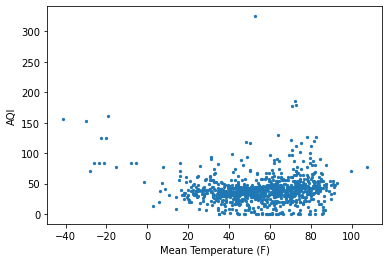

In [177]:
plt.scatter(final_data_set['Mean Temperature (F)'].sample(frac=0.01, random_state=10), final_data_set['AQI'].sample(frac=0.01, random_state=10), s=5)
plt.xlabel("Mean Temperature (F)")
plt.ylabel("AQI")
plt.savefig('AQI_MT_scatter.png')

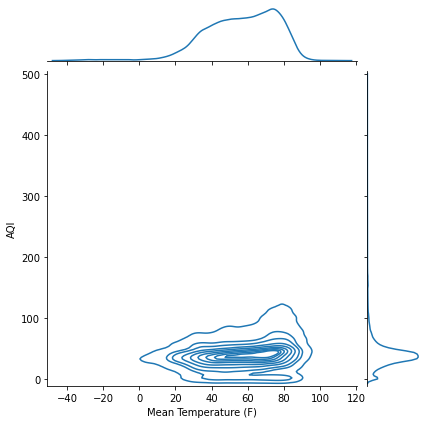

In [102]:
sns.jointplot(x=final_data_set['Mean Temperature (F)'], y=final_data_set['AQI'], kind="kde")
plt.savefig('AQI_MT_kde.png')

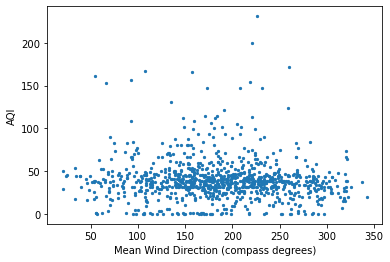

In [89]:
plt.scatter(final_data_set['Mean Wind Direction (compass degrees)'].sample(frac=0.01, random_state=10), final_data_set['AQI'].sample(frac=0.01, random_state=10), s=5)
plt.xlabel("Mean Wind Direction (compass degrees)")
plt.ylabel("AQI")
plt.savefig('AQI_MWD_scatter.png')

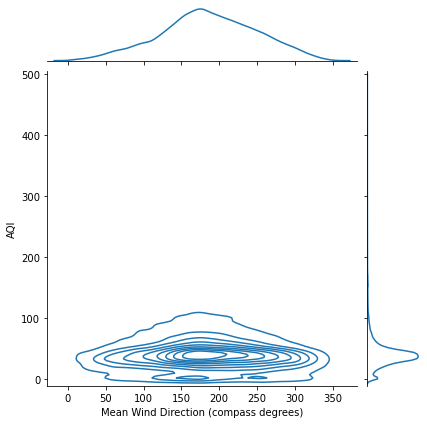

In [101]:
sns.jointplot(x=final_data_set['Mean Wind Direction (compass degrees)'], y=final_data_set['AQI'], kind="kde")
plt.savefig('AQI_MWD_kde.png')

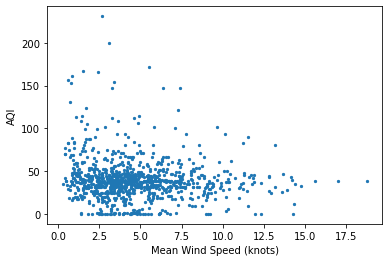

In [91]:
plt.scatter(final_data_set['Mean Wind Speed (knots)'].sample(frac=0.01, random_state=10), final_data_set['AQI'].sample(frac=0.01, random_state=10), s=5)
plt.xlabel("Mean Wind Speed (knots)")
plt.ylabel("AQI")
plt.savefig('AQI_MWS_scatter.png')

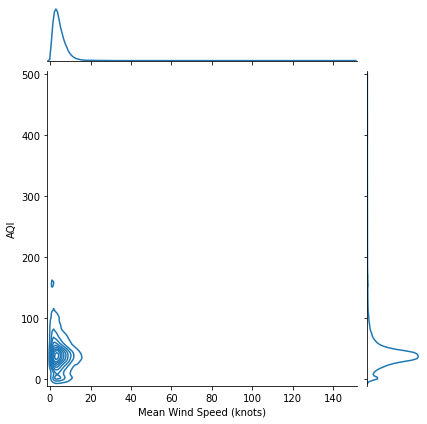

In [100]:
sns.jointplot(x=final_data_set['Mean Wind Speed (knots)'], y=final_data_set['AQI'], kind="kde")
plt.savefig('AQI_MWS_kde.png')

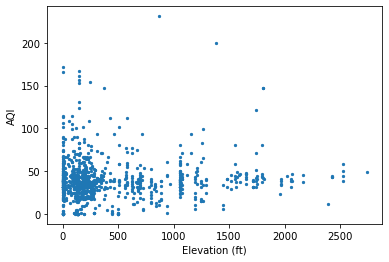

In [103]:
plt.scatter(final_data_set['Elevation'].sample(frac=0.01, random_state=10), final_data_set['AQI'].sample(frac=0.01, random_state=10), s=5)
plt.xlabel("Elevation (ft)")
plt.ylabel("AQI")
plt.savefig('AQI_ELE_scatter.png')

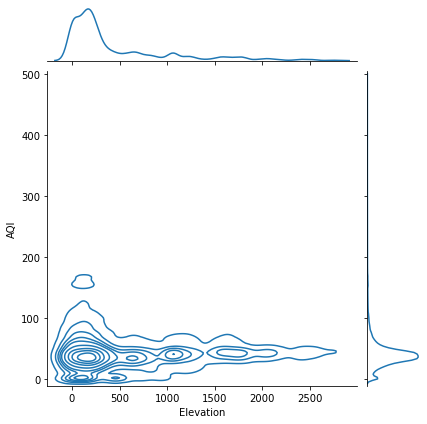

In [99]:
sns.jointplot(x=final_data_set['Elevation'], y=final_data_set['AQI'], kind="kde")
plt.xlabel("Elevation (ft)")
plt.ylabel("AQI")
plt.savefig('AQI_ELE_kde.png')

Text(0.5, 1.0, 'AQI vs Annual Xylene')

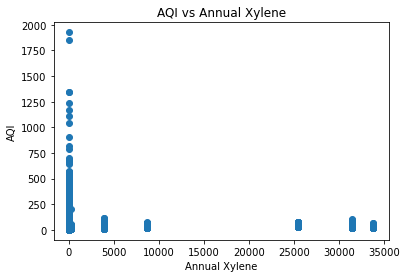

In [56]:
plt.scatter(final_data_set["Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)"], final_data_set['AQI'])
plt.xlabel("Annual Xylene")
plt.ylabel("AQI")
plt.title("AQI vs Annual Xylene")

In [57]:
c = [ chem.strip() for chem in chemical_names]

c.remove('Benzyl chloride')
c.remove('Malathion')
c.remove("Trichlorofluoromethane (CFC-11)")
final_data_set[np.array(c)]

# ['Benzyl chloride', 'Malathion', 'Trichlorofluoromethane (CFC-11)']


,"Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)",Lead compounds,Lead,Manganese,Dinitrotoluene (mixed isomers),Nitroglycerin,Dibutyl phthalate,Nonylphenol Ethoxylates,Copper,Nickel,...,Molybdenum trioxide,"1,2-Butylene oxide",Acetaldehyde,Propionaldehyde,Phenanthrene,Dinitrobutyl phenol,Dibenzofuran,"1,2-Dibromoethane",Creosote,Arsenic compounds
0,25409.0,37.56,18.89,31.0,0.0,0.0,0.0,0.0,15.37,90.8,...,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25409.0,37.56,18.89,31.0,0.0,0.0,0.0,0.0,15.37,90.8,...,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25409.0,37.56,18.89,31.0,0.0,0.0,0.0,0.0,15.37,90.8,...,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25409.0,37.56,18.89,31.0,0.0,0.0,0.0,0.0,15.37,90.8,...,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25409.0,37.56,18.89,31.0,0.0,0.0,0.0,0.0,15.37,90.8,...,0.0,0.0,41000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94561,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94562,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94563,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94564,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<bound method Figure.tight_layout of <Figure size 1080x1080 with 4 Axes>>

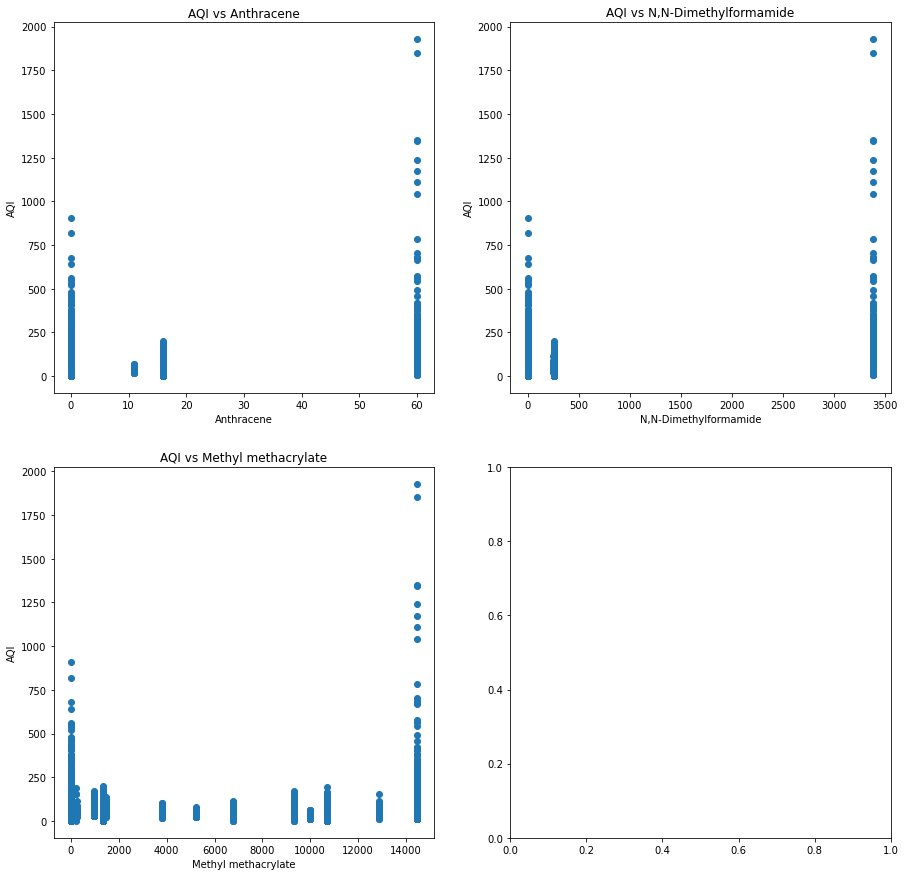

In [58]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
cns =  ["Anthracene","N,N-Dimethylformamide","Methyl methacrylate"]
axs = axs[0:3].flatten()

for ax, chem in zip(axs,cns):
    ax.scatter(final_data_set[chem], final_data_set['AQI'])
    ax.set_xlabel(f"{chem}")
    ax.set_ylabel("AQI")
    ax.set_title(f"AQI vs {chem}")

fig.tight_layout

## There does not appear to be any feature engineering that we could do to increase the correlation between the data is all over the place

## Correlation heatmap of the numeric features we have chosen and AQI

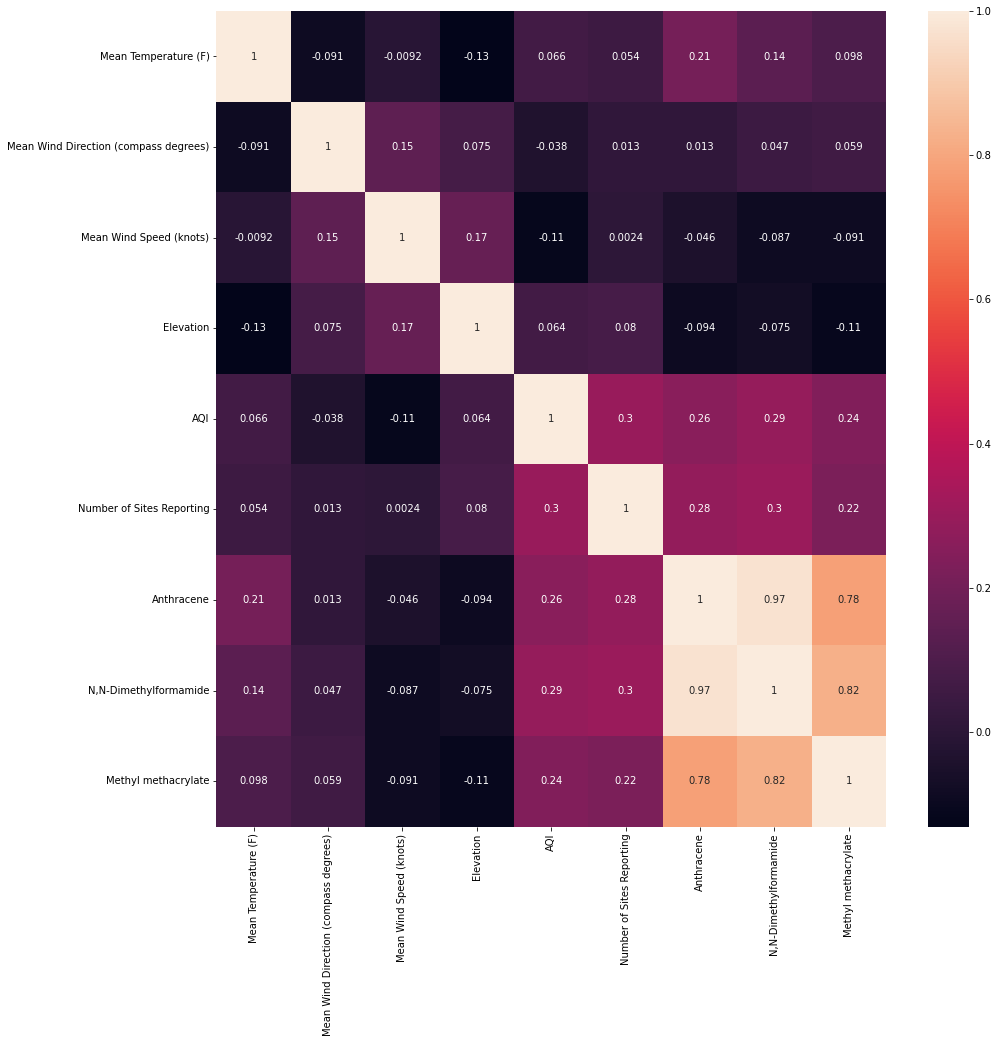

In [106]:
plt.figure(figsize=(15, 15))
correlation = final_data_set[['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation', 'AQI', 'Number of Sites Reporting', "Anthracene","N,N-Dimethylformamide","Methyl methacrylate"]].corr()
sns.heatmap(correlation, annot=True)
plt.savefig('correlation.png')

## There is little correlation between the features we have chosen and AQI.

## Encoding Categorical features

In [178]:
import numpy as np
# Define any additional helper functions you need here
def scale_feature(data, col):
    data[col] = (data[col] - data[col].min())/(data[col].max()-data[col].min())
    return data

def process_pipelines(data, pipelines):
    for function, arguments, keyword_arguments in pipelines:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data
     
def get_cols(data,numeric,encoded):
    selected = numeric
    [selected.extend([f"{e}_{v}" for v in data[e].unique()]) for e in encoded]
    return selected

def root(data,col):
    data[col] = data[col]**(1/2)
    return data

def cube(data,col):
    data[col] = data[col]**(3)
    return data

def encode_categorical(data,**kwargs):
    data = pd.get_dummies(data,**kwargs)
    return data


def outliar_bounds(data,col):
    
    quant3 = np.quantile(data[col], 0.75)
    quant1 = np.quantile(data[col], 0.25)
    
    iqr = quant3 - quant1
 
    bound_l= quant1 - 1.5 * iqr
    bound_u = quant3 + 1.5 * iqr
    
    return {'variable': col,'lower': bound_l, 'upper': bound_u}

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[data[variable].ge(lower) & data[variable].le(upper)]
        
    
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, regression, is_test_set=False):
    
    encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting', 'Defining Parameter']
    select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation', 'Number of Sites Reporting', 'Category', "Anthracene","N,N-Dimethylformamide","Methyl methacrylate"]

    m3_pipelines = []
        
    m3_pipelines.extend([
    (encode_categorical,None, {'columns': encode_cols}),
    (select_columns, get_cols(data,select_cols,encode_cols), None)
    ])
    if not is_test_set:        
        select_cols.append('AQI')
        m3_pipelines.extend([
            (remove_outliers, None, outliar_bounds(data,'AQI')),
        ])


    data = process_pipelines(data, m3_pipelines)
    
    
    # Return predictors and response variables separately
    if is_test_set:
        return data.drop(['Category'], axis = 1)
    else:
        if regression == "Linear":
            X = data.drop(['AQI', 'Category'], axis = 1)
            y = data.loc[:, 'AQI']
        elif regression == 'Logistic':
        # For logistic regression:
            X = data.drop(['AQI', 'Category'], axis = 1)
            y = data.loc[:, 'Category']
        return X, y

## Attempting cross validation using holdout

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting']
#select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
#   'Mean Wind Speed (knots)', 'Elevation','BIOCO2', 'CH4', 'CO2', 'N2O']

print(final_data_set.shape)
#display(final_data_set[final_data_set.isna().any(axis=1)])

#remove NaN values
final_data_set = final_data_set.dropna()

print(final_data_set.shape)
#print(complete_data_set.shape)
# Processing data
X, y = process_data_fm(final_data_set, "Linear")

#display(X.iloc[:, 0:4])

# Resetting columns to avoid NaN values when joining below
X = X.reset_index().drop(columns='index')
y = y.reset_index().drop(columns='index').squeeze()

# Select numeric values and encoded values seperately
X_encoded = X.iloc[:, 5:]
X_numeric = X.iloc[:, 0:5]

scaler.fit(X_numeric)

X_numeric_scaled = pd.DataFrame(scaler.transform(X_numeric), columns=X_numeric.columns)

X_scaled_encoded = X_numeric_scaled.join(X_encoded)

display(X_scaled_encoded)

# ONLY training and validation for now
# Un-scaled values to use with regular linear model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=69)

# Scaled values to use with regularized models (lasso, and ridge)
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_scaled_encoded, y, test_size=0.2,random_state=69)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=69)


(94541, 168)
(94015, 168)


,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Number of Sites Reporting,Anthracene,"N,N-Dimethylformamide",Methyl methacrylate,County Name_Jefferson,County Name_Denali,County Name_Fairbanks North Star,County Name_Cochise,County Name_Coconino,County Name_Maricopa,County Name_Navajo,County Name_Pima,County Name_Pulaski,County Name_Amador,County Name_Butte,County Name_Calaveras,County Name_Colusa,County Name_El Dorado,County Name_Fresno,County Name_Glenn,County Name_Imperial,County Name_Inyo,County Name_Kern,County Name_Kings,County Name_Los Angeles,County Name_Madera,County Name_Mariposa,County Name_Merced,County Name_Mono,County Name_Orange,County Name_Placer,County Name_Riverside,County Name_Sacramento,County Name_San Benito,County Name_San Bernardino,County Name_San Diego,...,City Name_kennewick,City Name_west wenatchee,City Name_quincy,City Name_enumclaw,City Name_seattle,City Name_tacoma,City Name_spokane,City Name_colville,City Name_burbank,City Name_ferndale,City Name_toppenish,City Name_charleston,City Name_madison,City Name_horicon,City Name_pleasant prairie,City Name_kenosha,City Name_milwaukee,City Name_rhinelander,City Name_waukesha,City Name_riverton,City Name_brookhurst,City Name_james town,Land Use_COMMERCIAL,Land Use_RESIDENTIAL,Land Use_FOREST,Land Use_DESERT,Land Use_AGRICULTURAL,Land Use_INDUSTRIAL,Land Use_MOBILE,Land Use_MILITARY RESERVATION,Land Use_BLIGHTED AREAS,Location Setting_URBAN AND CENTER CITY,Location Setting_RURAL,Location Setting_SUBURBAN,Defining Parameter_PM2.5,Defining Parameter_NO2,Defining Parameter_Ozone,Defining Parameter_PM10,Defining Parameter_SO2,Defining Parameter_CO
0,-0.218074,-0.782456,0.081918,-0.499139,2.513736,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0.516748,-0.367016,0.957497,-0.499139,2.513736,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0.418996,0.339493,-0.485915,-0.499139,2.513736,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0.099450,-1.746173,0.422345,-0.499139,2.513736,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,-0.065941,-1.278640,0.273919,-0.499139,2.139941,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84808,-0.451779,-0.019947,-0.619362,3.138189,0.270968,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
84809,-0.564137,-0.383295,-0.773235,3.138189,0.270968,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
84810,-0.528183,-0.278458,-0.534936,3.138189,0.270968,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
84811,-0.600092,-0.289528,-0.667022,3.138189,0.644763,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [180]:
print(X_train.shape)
print(X_val.shape)

(67850, 664)
(16963, 664)


# Linear Regression models


### define a model

In [181]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
import sklearn.linear_model as lm


# Attempting both lasso and Ridge regularization models
lasso_model = Lasso()
ridge_model = Ridge()
linear_model = lm.LinearRegression()

### Fit model

In [182]:
#Fitting the models
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train_scaled, y_train_scaled)
ridge_model.fit(X_train_scaled, y_train_scaled)

y_pred_train_linear = linear_model.predict(X_train)
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
y_pred_train_ridge = ridge_model.predict(X_train_scaled)

y_pred_val_linear = linear_model.predict(X_val)
y_pred_val_lasso = lasso_model.predict(X_val_scaled)
y_pred_val_ridge = ridge_model.predict(X_val_scaled)

linear_val_predictions = pd.DataFrame(y_pred_val_linear)

# Model Predictions
from sklearn.metrics import mean_squared_error

print(f'Training MSE using Linear regression: {mean_squared_error(y_train, y_pred_train_linear)}')
print(f'Training MSE using LASSO regression: {mean_squared_error(y_train_scaled, y_pred_train_lasso)}')
print(f'Training MSE using Ridge regression: {mean_squared_error(y_train_scaled, y_pred_train_ridge)}')
print("")
print(f'Validation MSE using Linear regression: {mean_squared_error(y_val, y_pred_val_linear)}')
print(f'Validation MSE using LASSO regression: {mean_squared_error(y_val_scaled, y_pred_val_lasso)}')
print(f'Validation MSE using Ridge regression: {mean_squared_error(y_val_scaled, y_pred_val_ridge)}')


Training MSE using Linear regression: 119.35976628098604
Training MSE using LASSO regression: 160.86254879380638
Training MSE using Ridge regression: 119.41179322897057

Validation MSE using Linear regression: 120.06981393219776
Validation MSE using LASSO regression: 160.9419128749916
Validation MSE using Ridge regression: 120.02823336836101


# Logistic Regression Model

In [183]:
final_data_set.groupby('Category').size()

Category
Good                              76208
Hazardous                            57
Moderate                          15198
Unhealthy                           859
Unhealthy for Sensitive Groups     1594
Very Unhealthy                       99
dtype: int64

## Attempting cross validation using holdout

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting']
#select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
#   'Mean Wind Speed (knots)', 'Elevation','BIOCO2', 'CH4', 'CO2', 'N2O']

print(final_data_set.shape)
#display(final_data_set[final_data_set.isna().any(axis=1)])

#remove NaN values
final_data_set_2 = final_data_set.dropna()

print(final_data_set.shape)
#print(complete_data_set.shape)
# Processing data
X, y = process_data_fm(final_data_set_2, 'Logistic')

#display(X.iloc[:, 0:4])

# Resetting columns to avoid NaN values when joining below
X = X.reset_index().drop(columns='index')
y = y.reset_index().drop(columns='index').squeeze()

# Select numeric values and encoded values seperately
X_encoded = X.iloc[:, 5:]
X_numeric = X.iloc[:, 0:5]

scaler.fit(X_numeric)

X_numeric_scaled = pd.DataFrame(scaler.transform(X_numeric), columns=X_numeric.columns)

X_scaled_encoded = X_numeric_scaled.join(X_encoded)

# ONLY training and validation for now
# Un-scaled values to use with regular linear model
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X, y, test_size=0.2,random_state=69)
print(X_train_log.shape)
print(X_val_log.shape)

(94015, 168)
(94015, 168)
(67850, 664)
(16963, 664)


In [185]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(multi_class="ovr", solver='newton-cg')
logistic_regression_model.fit(X_train_log, y_train_log)

LogisticRegression(multi_class='ovr', solver='newton-cg')

In [186]:
lr_training_accuracy = logistic_regression_model.score(X_train_log, y_train_log)
lr_validation_accuracy = logistic_regression_model.score(X_val_log, y_val_log)

In [187]:
lr_training_accuracy

0.8686956521739131

In [188]:
lr_validation_accuracy

0.871072333903201

# Visualize results: Linear Regression Model

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1.0, 'Ridge Regression')

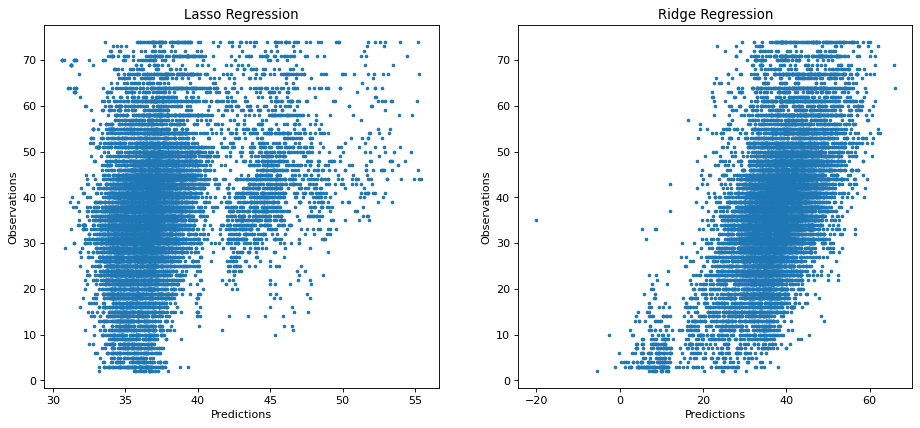

In [190]:
# Predictions vs Observations plots for validation
plt.figure(figsize=(14, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_lasso, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Lasso Regression")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_ridge, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Ridge Regression")


Text(0.5, 1.0, 'Ridge Regression')

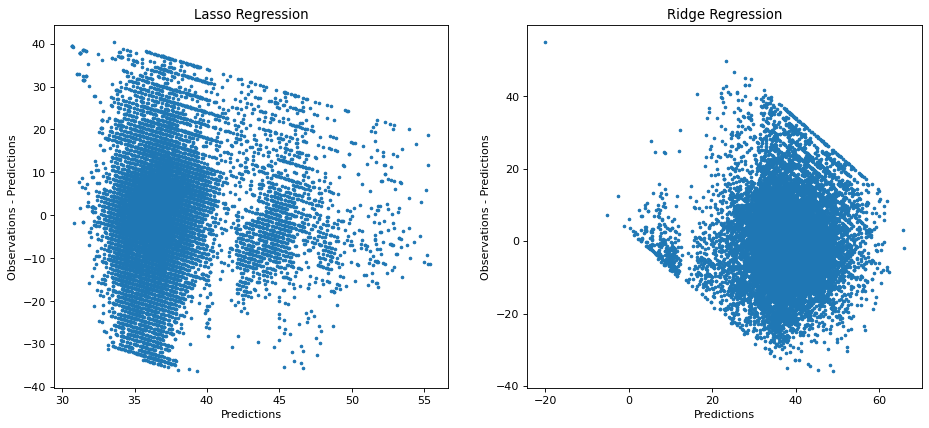

In [191]:
# Plot residuals for validation set

plt.figure(figsize=(14, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_lasso, y_val_scaled-y_pred_val_lasso, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Lasso Regression")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_ridge, y_val_scaled-y_pred_val_ridge, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Ridge Regression")

In [192]:
import sklearn

print(f'R^2 for Linear on validation: {sklearn.metrics.r2_score(y_val, y_pred_val_linear)}')
print(f'R^2 for LASSO on validation: {sklearn.metrics.r2_score(y_val_scaled, y_pred_val_lasso)}')
print(f'R^2 for Ridge on validation: {sklearn.metrics.r2_score(y_val_scaled, y_pred_val_ridge)}')

R^2 for Linear on validation: 0.32699040433485604
R^2 for LASSO on validation: 0.09789606427859043
R^2 for Ridge on validation: 0.32722346972855354


# Visualize Results: Logistic Regression Model

In [193]:
# Grouped bar chart to show correct vs incorrect predictions
validation_predictions_log = logistic_regression_model.predict(X_val_log)
logistic_output = pd.DataFrame(validation_predictions_log, y_val_log).reset_index().rename(columns={'Category': 'Observation', 0: 'Prediction'})

Text(0.5, 1.0, 'Correct Predictions by Observation Type')

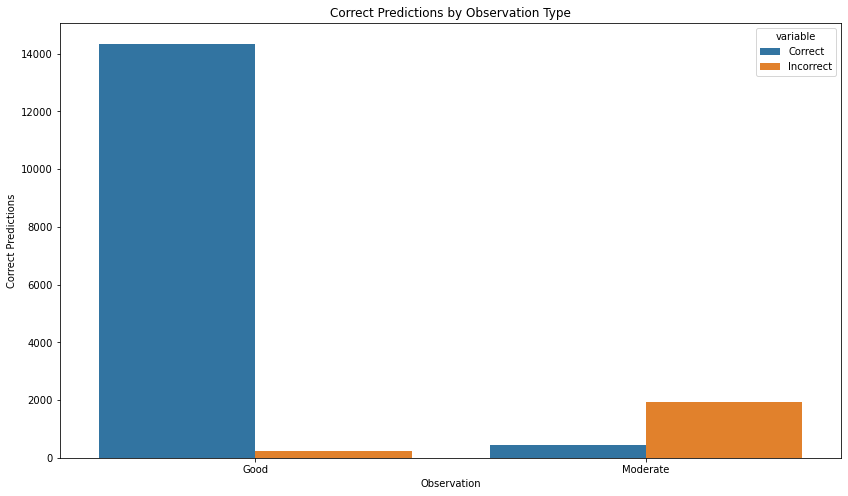

In [194]:
import seaborn as sns
# There are only Good and Moderate observations because the outliers were removed
logistic_output
C = np.where(logistic_output['Observation'] == logistic_output['Prediction'], 1, 0)
I = np.where(logistic_output['Observation'] != logistic_output['Prediction'], 1, 0)
logistic_output["Correct"] = C
logistic_output["Incorrect"] = I
grouped_logistic_output = logistic_output.groupby('Observation').sum().reset_index()
to_plot = grouped_logistic_output.melt(id_vars=['Observation'])


plt.figure(figsize=(14, 8))
sns.barplot(data=to_plot, x='Observation', y='value', hue='variable')
plt.ylabel("Correct Predictions")
plt.title("Correct Predictions by Observation Type")

## There are only Good and Moderate observations because the outliers were removed. Our logistic model can predict the "Good" AQI category very well but struggles greatly with predicting the "Moderate" AQI category. It appears that the overall accuracy is very high due to the class imbalance present.

## Using a confusion matrix approach instead to quantify how good the logistic regression model is

In [209]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_pred=logistic_output['Prediction'], y_true=y_val_log)

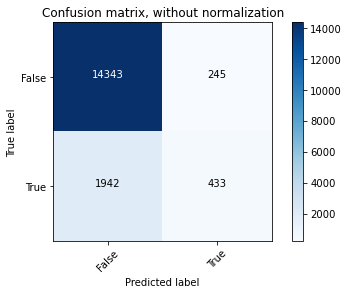

In [212]:
# Taken from lab 12
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    
class_names = ['False', 'True']

plot_confusion_matrix(confusion_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

## Quantifying Precision and Recall for the logistic Regression Model

In [211]:
TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TP = confusion_matrix[1][1]

precision = TP / (TP  + FP)
recall = TP / (TP + FN)

print(f'Precision of the logistic regression model is: {precision}')
print(f'Recall of the logistic regression model is: {recall}')

Precision of the logistic regression model is: 0.6386430678466076
Recall of the logistic regression model is: 0.1823157894736842


## The Precision and Recall of the logistic regression model are 0.639 and 0.182, respectively. Indicating that our  model has a lot of false negatives.

### Hyper parameter tuning to improve predictions on Ridge Regression Model

#### data is already scaled above

In [77]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': 10**np.linspace(-5, 4, 40)}

grid_search = GridSearchCV(Ridge(), params, cv = 4, scoring = "neg_root_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.70125428e-05, 2.89426612e-05, 4.92388263e-05,
       8.37677640e-05, 1.42510267e-04, 2.42446202e-04, 4.12462638e-04,
       7.01703829e-04, 1.19377664e-03, 2.03091762e-03, 3.45510729e-03,
       5.87801607e-03, 1.00000000e-02, 1.70125428e-02, 2.89426612e-02,
       4.92388263e-02, 8.37677640e-02, 1.42510267e-01, 2....6202e-01,
       4.12462638e-01, 7.01703829e-01, 1.19377664e+00, 2.03091762e+00,
       3.45510729e+00, 5.87801607e+00, 1.00000000e+01, 1.70125428e+01,
       2.89426612e+01, 4.92388263e+01, 8.37677640e+01, 1.42510267e+02,
       2.42446202e+02, 4.12462638e+02, 7.01703829e+02, 1.19377664e+03,
       2.03091762e+03, 3.45510729e+03, 5.87801607e+03, 1.00000000e+04])},
             scoring='neg_root_mean_squared_error')

In [78]:
grid_search.cv_results_['mean_test_score']

array([-11.01767974, -11.01767961, -11.01767939, -11.01767905,
       -11.01767855, -11.01767787, -11.0176772 , -11.01767711,
       -11.01767907, -11.01768544, -11.0176984 , -11.01771692,
       -11.01773416, -11.01773811, -11.01771471, -11.01764916,
       -11.01752511, -11.01732552, -11.01704017, -11.01668272,
       -11.0163148 , -11.01606989, -11.01618163, -11.01704405,
       -11.01932134, -11.02408717, -11.032948  , -11.04812681,
       -11.07267725, -11.11103688, -11.16935852, -11.25421231,
       -11.36899396, -11.50982631, -11.66509964, -11.82102088,
       -11.96820032, -12.10238673, -12.22159471, -12.32635584])

In [79]:
grid_search.best_score_

-11.016069887587097

In [80]:
grid_search.best_estimator_

Ridge(alpha=0.7017038286703837)

In [81]:
predicted_values_on_ridge_model_train = grid_search.best_estimator_.predict(X_train_scaled)
predicted_values_on_ridge_model_train

array([51.55732817, 37.76199337, 41.8747568 , ..., 43.7164266 ,
       34.75268228, 43.53523327])

In [82]:
predicted_values_on_ridge_model_val = grid_search.best_estimator_.predict(X_val_scaled)
predicted_values_on_ridge_model_val

array([39.14891525, 37.73777839, 33.66055284, ..., 49.40804755,
       31.75620071, 52.68039565])

In [83]:
print(f'Training MSE using optimized Ridge regression: {mean_squared_error(y_train_scaled, predicted_values_on_ridge_model_train)}')
print(f'Validation MSE using Ridge regression: {mean_squared_error(y_val_scaled, predicted_values_on_ridge_model_val)}')

Training MSE using optimized Ridge regression: 119.39453213224505
Validation MSE using Ridge regression: 120.03364268581498


Text(0.5, 1.0, 'Optimized Ridge Regression')

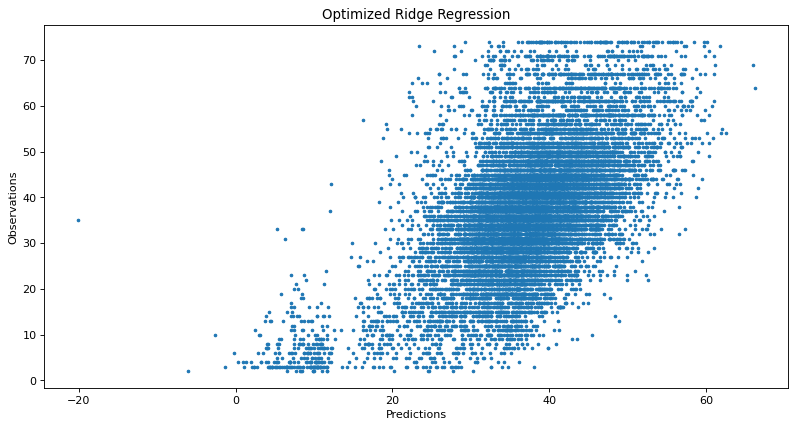

In [84]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(predicted_values_on_ridge_model_val, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Optimized Ridge Regression")

Text(0.5, 1.0, 'Optimized Ridge Regression Residuals')

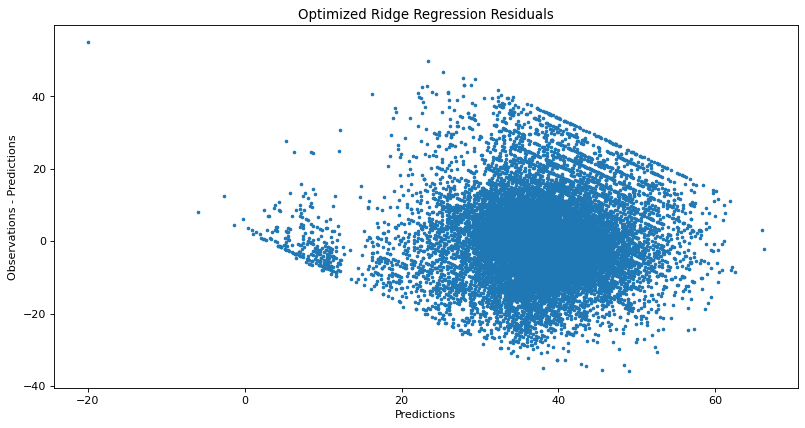

In [85]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(predicted_values_on_ridge_model_val, y_val_scaled-predicted_values_on_ridge_model_val, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Optimized Ridge Regression Residuals")

## Based on these figures of our final optimized ridge regression model, we see that our predictions are spread out horizontally and our residuals show a pattern. These observations are indicative of our model not being able to predict the AQI value accurately. Our logistic regression model is able to accurately predict ~87% of the observations which at first glance may seem very good, however it struggles with predicting other categories. These issues can be attributed to the fact that our features are not good predictors of AQI or its categories. Looking back at the feature engineering section, you can see that the correlations between the numeric features and AQI score are very poor, and there was no real way to transform the features so that they may be linear and give better predictive power. To improve these models, more data with better features would be necessary.